In [1]:
import os
import re
import ROOT
import uproot
import numpy as np

import matplotlib.pyplot as plt
%matplotlib widget

Welcome to JupyROOT 6.28/11


In [2]:
def gaussian(x, mu, sig):
    return (1/(sig*np.sqrt(2.*np.pi)))*np.exp(-(x-mu)**2/(2*sig**2))

In [3]:
# get 3D histogram
fname = os.path.expandvars("$HOME/Software/HK_Software/WCSimFQTuningTools/Time/old_tools/11_tpdfhist.root")
with uproot.open(fname) as f: H, tresbins, trueqbins, omombins = f["hist_tpdf"].to_numpy()

# compute bin centers
omoms  = (omombins  [1:] + omombins  [:-1])/2.
trueqs = (trueqbins[1:] + trueqbins[:-1])/2.
tress  = (tresbins [1:] + tresbins [:-1])/2.

# old file
ofname = os.path.expandvars("$HOME/Software/HK_Software/WCSimFQTuningTools/Time/old_tools/11_tpdfpar.root")
of = uproot.open(ofname)

# new file
fname = "/pbs/home/g/gdiazlop/Software/HK_Software/WCSimFQTuningTools/Time/fitted_timepdf.root"
f = ROOT.TFile(fname)
mean_th2d  = f.Get("mean")
sigma_th2d = f.Get("sigma")

In [4]:
# choose a random momentum and read mean values
mom = int(np.random.choice(omoms))
print("p = ", mom)

# old file
omeans, trueqbins_  = of[f"hmean_{mom}"].to_numpy()
assert (trueqbins_ == trueqbins).all()
osigmas, trueqbins_ = of[f"hsigm_{mom}"].to_numpy()
assert (trueqbins_ == trueqbins).all()
# # equivalent, use 2D (p, trueq) hmean_step0
# # better not to use because it contains failed fit as non-zeros
# hmean_step0, mombins_, trueqbins_ = f["hmean_step0"].to_numpy()
# assert (mombins_ == mombins).all()
# assert (trueqbins_ == trueqbins).all()

# new file
pi = int(np.digitize(mom, omombins) - 1)
means  = np.array([mean_th2d .GetBinContent(pi+1, i) for i in range(1, len(trueqs)+1)])
sigmas = np.array([sigma_th2d.GetBinContent(pi+1, i) for i in range(1, len(trueqs)+1)])

# plt.figure()
# plt.scatter(means, omeans)
# # plt.scatter(sigmas, osigmas)
# plt.xlabel("new")
# plt.ylabel("old")
# plt.tight_layout()

p =  150


Nentries: 2932.0
old -0.8312528948778687 0.9647093645899739
new -0.7981185809010779 0.9080186660548918


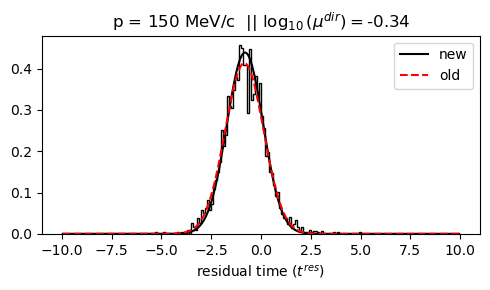

In [6]:
# choose random trueq
trueq = np.random.choice(trueqs)

# find tres projection
pi  = np.digitize(mom, omombins)-1
tqi = np.digitize(trueq, trueqbins)-1
proj = H[:, tqi, pi]
norm = np.sum(proj * (tresbins[1:] - tresbins[:-1]))

# old 
omu  = omeans [tqi]
osig = osigmas[tqi]

# new
mu  = means [tqi]
sig = sigmas[tqi]

print("Nentries:", proj.sum())
print("old", omu, osig)
print("new", mu, sig)

# plot
plt.figure(figsize=[5, 3])

plt.title(f"p = {mom} MeV/c  || " + r"$\log_{10}(\mu^{dir})=$" + f"{round(trueq, 3)}")

plt.stairs(proj/norm, tresbins, color="k")
plt.plot(tress, gaussian(tress,  mu,  sig), color="k", label="new")
plt.plot(tress, gaussian(tress, omu, osig), color="r", label="old", linestyle="--")
plt.xlabel(r"residual time ($t^{res}$)")

plt.legend()
plt.tight_layout()

In [8]:
# Polynomial fit
npars = 5

# new
with uproot.open(fname) as f_:
    # get params
    mean_pars  = []
    sigma_pars = []
    for i in range(npars):
        _, pars_ = f_[f"gtcmnpar_{i}"].values()
        mean_pars.append(pars_[pi])
        _, pars_ = f_[f"gtcsgpar_{i}"].values()
        sigma_pars.append(pars_[pi])
mean_pars  = np.array(mean_pars)
sigma_pars = np.array(sigma_pars)


# old
# need to read using ROOT since TGraphErrors reading not implemented in uproot
ofroot = ROOT.TFile(ofname)

omean_pars  = []
osigma_pars = []
for i in range(npars):
    g = ofroot.Get(f"gtcmnpar_{i}")
    omean_pars.append(g.GetPointY(int(pi)))
    g = ofroot.Get(f"gtcsgpar_{i}")
    osigma_pars.append(g.GetPointY(int(pi)))
omean_pars  = np.array(omean_pars)
osigma_pars = np.array(osigma_pars)

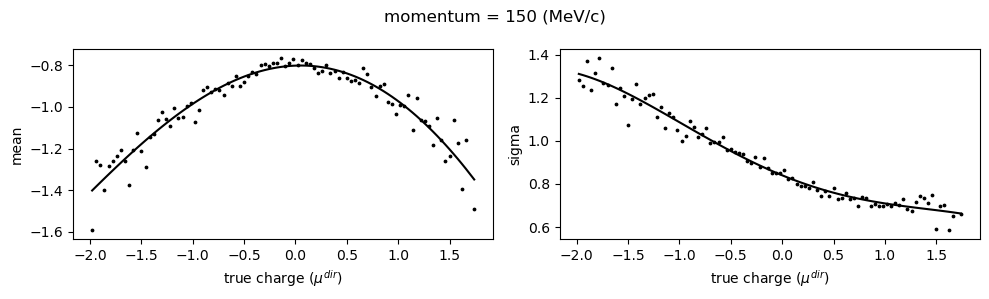

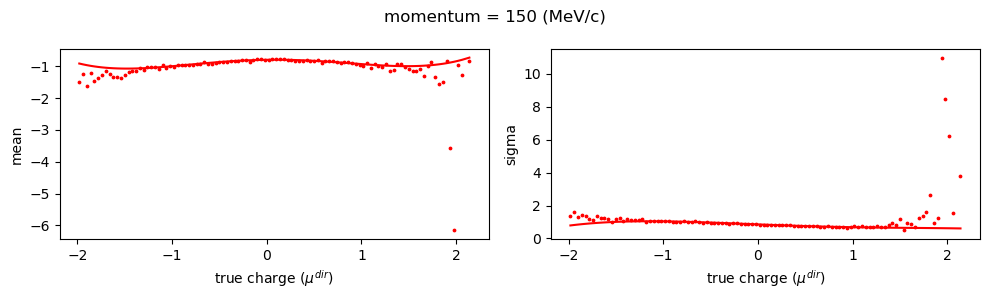

In [12]:
# new
plt.figure(figsize=[10, 3])
plt.suptitle(f"momentum = {mom} (MeV/c)")

# mean
plt.subplot(121)
sel = ~np.isnan(means)
plt.scatter(trueqs[sel], means[sel], s=3, color="k")
poly = np.poly1d(np.flip(mean_pars))
plt.plot(trueqs[sel], poly(trueqs[sel]), color="k")
plt.xlabel(r"true charge ($\mu^{dir}$)")
plt.ylabel("mean")

plt.subplot(122)
sel = ~np.isnan(sigmas)
plt.scatter(trueqs[sel], sigmas[sel], s=3, color="k")
poly = np.poly1d(np.flip(sigma_pars))
plt.plot(trueqs[sel], poly(trueqs[sel]), color="k")
plt.xlabel(r"true charge ($\mu^{dir}$)")
plt.ylabel("sigma")

plt.tight_layout()


# old
plt.figure(figsize=[10, 3])
plt.suptitle(f"momentum = {mom} (MeV/c)")

# mean
plt.subplot(121)
sel = (omeans != 0)
plt.scatter(trueqs[sel], omeans[sel], s=3, color="r")
poly = np.poly1d(np.flip(omean_pars))
plt.plot(trueqs[sel], poly(trueqs[sel]), color="r")
plt.xlabel(r"true charge ($\mu^{dir}$)")
plt.ylabel("mean")

plt.subplot(122)
sel = (osigmas != 0)
plt.scatter(trueqs[sel], osigmas[sel], s=3, color="r")
poly = np.poly1d(np.flip(osigma_pars))
plt.plot(trueqs[sel], poly(trueqs[sel]), color="r")
plt.xlabel(r"true charge ($\mu^{dir}$)")
plt.ylabel("sigma")

plt.tight_layout()

In [13]:
# read ultimate parameters
with uproot.open(fname) as f_:
    mean_pars_ , gaussbins, parsbins = f_["htpdfparmn"].to_numpy()
    sigma_pars_, gaussbins, parsbins = f_["htpdfparsg"].to_numpy()

omean_pars_ , _, _ = of["htpdfparmn"].to_numpy()
osigma_pars_, _, _ = of["htpdfparsg"].to_numpy()

In [14]:
# choose random parameter index
i = np.random.randint(npars)
print("Parameter index ", i)

# read parameter vs momenta
with uproot.open(fname) as f_: 
    moms, mnpars = f_[f"gtcmnpar_{i}"].values()
    moms, sgpars = f_[f"gtcsgpar_{i}"].values()

g = ofroot.Get(f"gtcmnpar_{i}")
omnpars = np.array([g.GetPointY(j) for j in range(len(omoms))])
g = ofroot.Get(f"gtcsgpar_{i}")
osgpars = np.array([g.GetPointY(j) for j in range(len(omoms))])

# get fit parameters
mean_pars  =  mean_pars_[i]
omean_pars = omean_pars_[i]

sigma_pars  =  sigma_pars_[i]
osigma_pars = osigma_pars_[i]

Parameter index  2


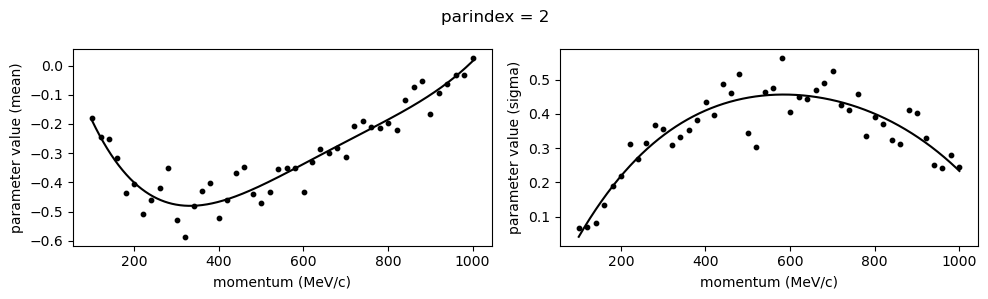

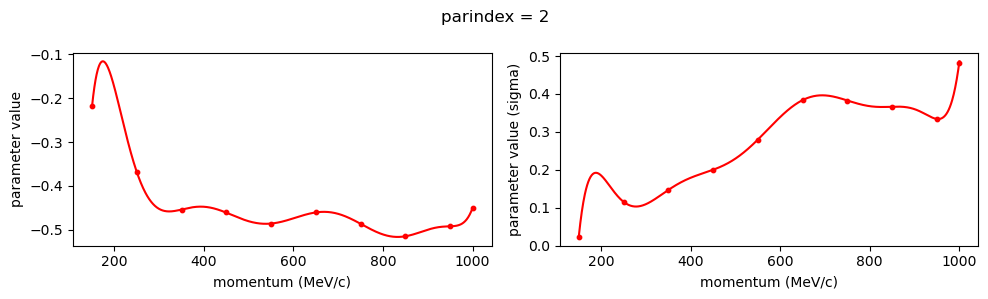

In [16]:
# new
plt.figure(figsize=[10, 3])
plt.suptitle(f"parindex = {i}")

# mean
plt.subplot(121)
plt.scatter(moms, mnpars, s=10, color="k")
poly = np.poly1d(np.flip(mean_pars))
x = np.linspace(moms[0], moms[-1], 1000)
plt.plot(x, poly(x), color="k")
plt.xlabel(r"momentum (MeV/c)")
plt.ylabel("parameter value (mean)")

plt.subplot(122)
plt.scatter(moms, sgpars, s=10, color="k")
poly = np.poly1d(np.flip(sigma_pars))
plt.plot(x, poly(x), color="k")
plt.xlabel(r"momentum (MeV/c)")
plt.ylabel("parameter value (sigma)")

plt.tight_layout()


# old
plt.figure(figsize=[10, 3])
plt.suptitle(f"parindex = {i}")

# mean
plt.subplot(121)
plt.scatter(omoms, omnpars, s=10, color="r")
poly = np.poly1d(np.flip(omean_pars))
x = np.linspace(omoms[0], omoms[-1], 1000)
plt.plot(x, poly(x), color="r")
plt.xlabel(r"momentum (MeV/c)")
plt.ylabel("parameter value")

plt.subplot(122)
plt.scatter(omoms, osgpars, s=10, color="r")
poly = np.poly1d(np.flip(osigma_pars))
plt.plot(x, poly(x), color="r")
plt.xlabel(r"momentum (MeV/c)")
plt.ylabel("parameter value (sigma)")

plt.tight_layout()